## Load deformer and visualize results

In [2]:
# load libraries
import trimesh
import torch
import json
import os
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from types import SimpleNamespace
# from utils import render
from shapenet_dataloader import ShapeNetMesh
from deepdeform.layers.deformation_layer import NeuralFlowDeformer

### Options

In [3]:
# choice of checkpoint to load
run_dir = "runs/symm_lat256_nosign_b32"  # "runs/pretrained_ckpt"
checkpoint = "checkpoint_latest.pth.tar_deepdeform_034.pth.tar" #  "checkpoint_latest.pth.tar_deepdeform_100.pth.tar"
device = torch.device("cuda")

### Setup

In [62]:
# load training args
args = SimpleNamespace(**json.load(open(os.path.join(run_dir, 'params.json'), 'r')))

# setup model
deformer = NeuralFlowDeformer(latent_size=args.lat_dims, f_width=args.deformer_nf, s_nlayers=2, 
                              s_width=5, method=args.solver, nonlinearity=args.nonlin, arch='imnet',
                              adjoint=args.adjoint, rtol=args.rtol, atol=args.atol, via_hub=True,
                              no_sign_net=(not args.sign_net), symm_dim=2)#(2 if args.symm else None))
lat_params = torch.nn.Parameter(torch.randn(4746, args.lat_dims)*1e-1, requires_grad=True)
deformer.add_lat_params(lat_params)
deformer.to(device)

# load checkpoint
resume_dict = torch.load(os.path.join(run_dir, checkpoint))
start_ep = resume_dict["epoch"]
global_step = resume_dict["global_step"]
tracked_stats = resume_dict["tracked_stats"]
deformer.load_state_dict(resume_dict["deformer_state_dict"])

# dataloader
data_root = args.data_root.replace('shapenet_watertight', 'shapenet_simplified')
dset = ShapeNetMesh(data_root=data_root, split="train", category="chair", 
                    normals=False)


### Plot a vector field

In [78]:
p = torch.tensor([.5, .5, .5]).to(device)[None, None]
p_ = torch.tensor([.5, .5, -.5]).to(device)[None, None]

val = deformer.net(torch.tensor([.5]).to(device), p)
val_ = deformer.net(torch.tensor([.5]).to(device), p_)

print(val.detach().cpu().numpy())
print(val_.detach().cpu().numpy())

[[[0.07209084 0.16889307 0.04300743]]]
[[[ 0.07209084  0.16889307 -0.04300743]]]


In [67]:
# plot vector field
lat = torch.randn(1, args.lat_dims).to(device)
deformer.net.update_latents(torch.stack([lat, lat+0.01], dim=1))

# query location
xyz = torch.stack(torch.meshgrid(torch.linspace(-.5, .5, 11),
                                 torch.linspace(-.5, .5, 11),
                                 torch.linspace(-.5, .5, 11)), dim=-1).reshape([1, -1, 3])
vel = deformer.net(torch.tensor([.5]).to(device), xyz.to(device))
vel = vel.reshape([11, 11, 11, 3]).detach().cpu().numpy()
xyz = xyz.detach().cpu().numpy()
xyz = xyz.reshape([11, 11, 11, 3])

x, y, z = xyz[..., 0], xyz[..., 1], xyz[..., 2]
u, v, w = vel[..., 0], vel[..., 1], vel[..., 2]

In [77]:
# np.allclose(vel[:5, :, :], vel[5:, :, :])
# np.allclose(vel[:, :5, :], vel[:, 5:, :])
np.allclose(vel[:, :, :5][:2], vel[:, :, -1:5:-1][:2])
# x.shape

False

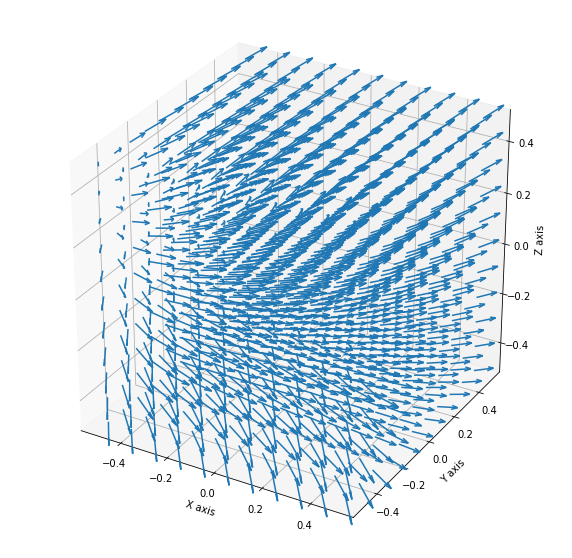

In [73]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

### Deformation between two shapes

Source latent shape: torch.Size([1, 512])
Target latent shape: torch.Size([1, 512])
Shape of all latent params: torch.Size([4746, 512])
Source v shape: torch.Size([1, 12507, 3]); f shape: torch.Size([25022, 3])
Target v shape: torch.Size([1, 14326, 3]); f shape: torch.Size([28684, 3])
Source to target v shape: torch.Size([12507, 3]); f shape: torch.Size([25022, 3])
Target to target v shape: torch.Size([14326, 3]); f shape: torch.Size([28684, 3])


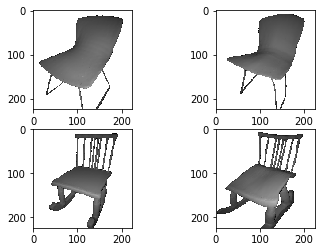

In [4]:
# pick source and target (between 0 and 4745)
source_idx = 0
target_idx = 1


# get the corresponding latent codes
source_latent = deformer.get_lat_params(source_idx)[None]   # unsqueeze batch dimension
target_latent = deformer.get_lat_params(target_idx)[None]   # unsqueeze batch dimension
zero_latent = torch.zeros_like(source_latent)  # "hub" latent
print(f"Source latent shape: {source_latent.shape}")
print(f"Target latent shape: {target_latent.shape}")


# access all latent parameters
all_latents = deformer.net.lat_params
print(f"Shape of all latent params: {all_latents.shape}")


# get the source and target shapes (meshes)
v_source, f_source = dset.get_single(source_idx)
v_target, f_target = dset.get_single(target_idx)
v_source = v_source[None].to(device)  # unsqueeze batch dimension
v_target = v_target[None].to(device)  # unsqueeze batch dimension
print(f"Source v shape: {v_source.shape}; f shape: {f_source.shape}")
print(f"Target v shape: {v_target.shape}; f shape: {f_target.shape}")


# deform source to target
lat_path = lambda l_src_, l_tar_: torch.stack([l_src_, zero_latent, l_tar_], dim=1)  # alias
with torch.no_grad():  # no need grad for inference
    v_src_to_tar = deformer(v_source, lat_path(source_latent, target_latent))[0]  # source to target
    v_tar_to_src = deformer(v_target, lat_path(target_latent, source_latent))[0]  # target to source
print(f"Source to target v shape: {v_src_to_tar.shape}; f shape: {f_source.shape}")
print(f"Target to target v shape: {v_tar_to_src.shape}; f shape: {f_target.shape}")


# convert to numpy
v_src_to_tar = v_src_to_tar.detach().cpu().numpy()
v_tar_to_src = v_tar_to_src.detach().cpu().numpy()
v_src = v_source[0].detach().cpu().numpy()
v_tar = v_target[0].detach().cpu().numpy()
f_src = f_source.detach().cpu().numpy()
f_tar = f_target.detach().cpu().numpy()

# render and visualize
img_src, _ = render.render_vf(v_src, f_src, color=[1.,1.,1.], res=(224,224))
img_tar, _ = render.render_vf(v_tar, f_tar, color=[1.,1.,1.], res=(224,224))
img_src_to_tar, _ = render.render_vf(v_src_to_tar, f_src, color=[1.,1.,1.], res=(224,224))
img_tar_to_src, _ = render.render_vf(v_tar_to_src, f_tar, color=[1.,1.,1.], res=(224,224))

# plot renderings
fig, axes = plt.subplots(ncols=2, nrows=2)
axes[0, 0].imshow(img_src)
axes[1, 0].imshow(img_tar)
axes[0, 1].imshow(img_src_to_tar)
axes[1, 1].imshow(img_tar_to_src)
plt.show()

### Visualize deformation between n shapes

  0%|          | 0/25 [00:00<?, ?it/s]

computing pairwise deformations...


100%|██████████| 25/25 [00:46<00:00,  1.88s/it]


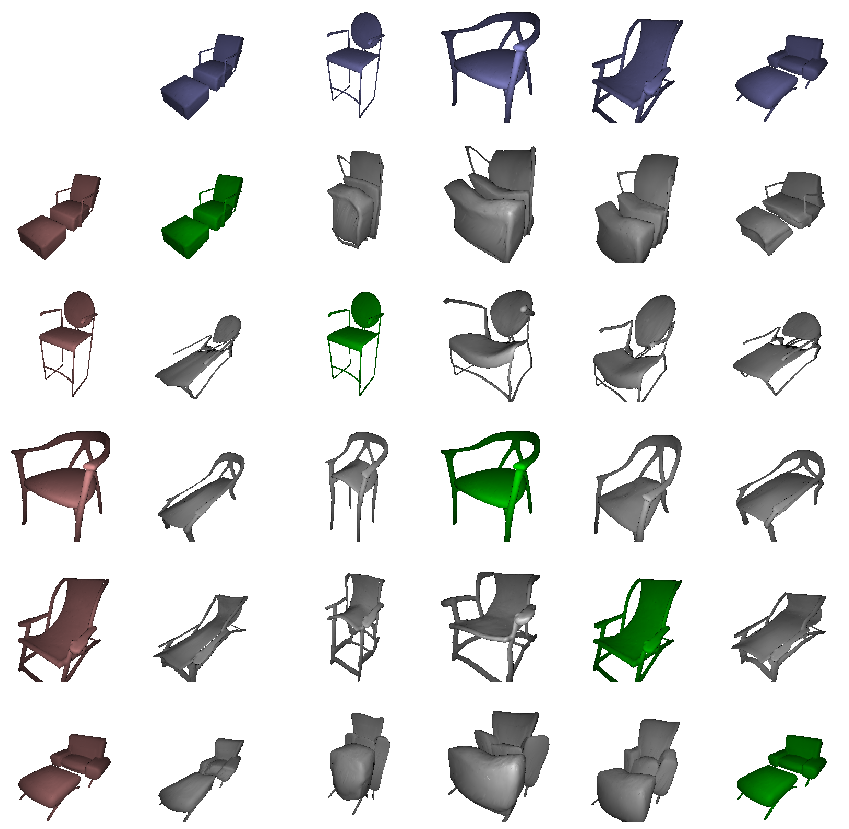

In [5]:
np.random.seed(1)
shape_indices = np.random.choice(4745, 5)  # choose between [0, 4745]

n = len(shape_indices)
imgs = [[None for _ in range(n)] for i in range(n)]
imgs_src = [None for _ in range(n)]
imgs_tar = [None for _ in range(n)]
faces = [None for _ in range(n)]
verts = [None for _ in range(n)]

for i, idx in enumerate(shape_indices):
    v, f = dset.get_single(idx)
    verts[i] = v[None].to(device)
    faces[i] = f.detach().cpu().numpy()
    
# deform all pairs
l_zero = torch.zeros_like(deformer.get_lat_params(0)[None] )
lat_path = lambda l_src_, l_tar_: torch.stack([l_src_, l_zero, l_tar_], dim=1)
ten2npy = lambda tensor: tensor.detach().cpu().numpy()

pbar = tqdm(total=n**2)
tqdm.write("computing pairwise deformations...")

with torch.no_grad():
    for i, ii in enumerate(shape_indices):
        for j, jj in enumerate(shape_indices):
            # get the latent codes corresponding to these shapes
            l_src = deformer.get_lat_params(ii)[None] 
            l_tar = deformer.get_lat_params(jj)[None]

            # deform src to target
            v_s2t = deformer(verts[i], lat_path(l_src, l_tar))[0]  # source to target
            if i == j:
                color = [0., 1., 0.]
            else:
                color = [1., 1., 1.]
            img, _ = render.render_vf(ten2npy(v_s2t), faces[i], 
                                      color=color, res=(224,224))
            imgs[i][j] = img
            pbar.update(1)
pbar.close()


# render colored imgs for source and target
for i in range(n):
    img_src, _ = render.render_vf(ten2npy(verts[i][0]), faces[i], 
                                  color=[1.,.4,.4], res=(224,224))
    img_tar, _ = render.render_vf(ten2npy(verts[i][0]), faces[i], 
                                  color=[.4,.4,1.], res=(224,224))
    imgs_src[i] = img_src
    imgs_tar[i] = img_tar

    
# plot transformation table
fig, axes = plt.subplots(figsize=(3*n, 3*n), nrows=n+1, ncols=n+1)
for i in range(0, n+1):
    for j in range(0, n+1):
        if i == 0 and j > 0:
            axes[i, j].imshow(imgs_tar[j-1])
        if i > 0 and j == 0:
            axes[i, j].imshow(imgs_src[i-1])
        if i > 0 and j > 0:
            axes[i, j].imshow(imgs[i-1][j-1])
        axes[i, j].axis('off')
plt.show()

## Visualize deformation to mean shapes (hub)

In [63]:
np.random.seed(1)
shape_indices = np.random.choice(4745, 5)  # choose between [0, 4745]
n = len(shape_indices)
imgs_src = [None for _ in range(n)]
imgs_tar = [None for _ in range(n)]
faces = [None for _ in range(n)]
verts = [None for _ in range(n)]  # verts tensor
mesh_o = [None for _ in range(n)]  # mesh original
mesh_d = [None for _ in range(n)]  # mesh deformed

for i, idx in enumerate(shape_indices):
    v, f = dset.get_single(idx)
    verts[i] = v[None].to(device)
    faces[i] = f.detach().cpu().numpy()

lat_path = lambda l_src_, l_tar_: torch.stack([l_src_, l_tar_], dim=1)
ten2npy = lambda tensor: tensor.detach().cpu().numpy()

pbar = tqdm(total=n)

with torch.no_grad():
    for i, ii in enumerate(shape_indices):
        # get the latent codes corresponding to these shapes
        l_src = deformer.get_lat_params(ii)[None] 
        l_tar = torch.zeros_like(l_src)  # target is the "hub"

        # deform source to target
        v_s2t = deformer(verts[i], lat_path(l_src, l_tar))[0]  # source to target
        mesh_d[i] = trimesh.Trimesh(ten2npy(v_s2t), faces[i], process=False)
        mesh_o[i] = trimesh.Trimesh(ten2npy(verts[i][0]), faces[i], process=False)
        pbar.update(1)
pbar.close()



100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


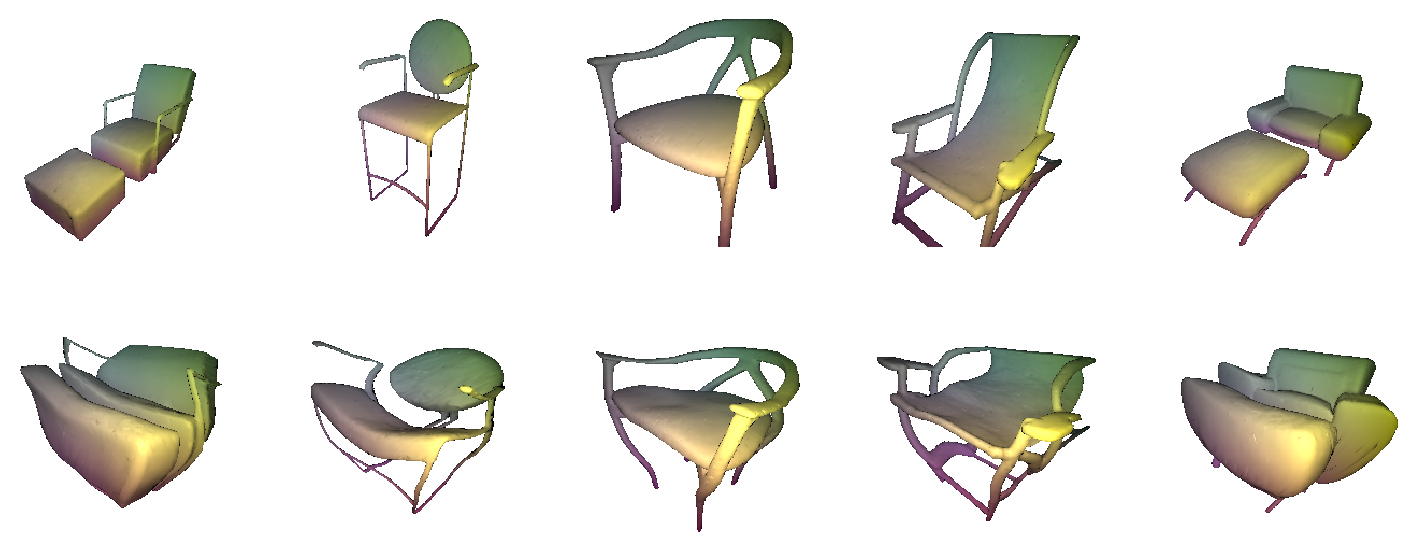

In [71]:
# colorize vertices based on mean shape coordinates
bboxes_d = [m.bounding_box.bounds for m in mesh_d]
bboxes_d = np.concatenate(bboxes_d, axis=0)
bboxes_d = np.stack([np.min(bboxes_d, axis=0), np.max(bboxes_d, axis=0)], axis=0)

for idx, (mo, md) in enumerate(zip(mesh_o, mesh_d)):
    color = (md.vertices.copy() - bboxes_d[0]) / (bboxes_d[1] - bboxes_d[0])
    md.visual.vertex_colors = color.copy()
    mo.visual.vertex_colors = color.copy()
    md_ = md.copy(); md_.vertices *= 0.5
    mo_ = mo.copy()
    img_tar, _ = render.render_trimesh(md_, color=[1., 1., 1.], res=(224, 224), dist=1.1, intensity=3)
    img_src, _ = render.render_trimesh(mo_, color=[1., 1., 1.], res=(224, 224), dist=1.1, intensity=3)
    
    imgs_src[idx] = img_src
    imgs_tar[idx] = img_tar
    
# plot transformation table
fig, axes = plt.subplots(figsize=(5*n, 10), nrows=2, ncols=n)
for i in range(n):
    axes[0, i].imshow(imgs_src[i])
    axes[1, i].imshow(imgs_tar[i])
    axes[0, i].axis('off')
    axes[1, i].axis('off')
plt.show()